In [114]:
import torch
import torch.nn as nn
from datetime import datetime 
import os
import matplotlib.pyplot as plt

In [115]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [116]:
in_path = ''

x_tensor = torch.load(os.path.join(in_path, "x_tensor")).to(torch.float32).to(device)
y_tensor = torch.load(os.path.join(in_path, "y_tensor")).to(torch.float32).to(device)

dataset = torch.utils.data.TensorDataset(x_tensor, y_tensor)

rng = torch.Generator().manual_seed(42)
training_set, val_set = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=rng)

In [117]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(input_size, 35),
          nn.ReLU(),
          nn.Linear(35, 64),
          nn.ReLU(),
          nn.Linear(64, 128),
          nn.ReLU(),
          nn.Linear(128, 256),
          nn.ReLU(),
          nn.Linear(256, 512),
          nn.ReLU(),
          nn.Linear(512, 256),
          nn.ReLU(),
          nn.Linear(256, 128),
          nn.ReLU(),
          nn.Linear(128, 64),
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.ReLU(),
          nn.Linear(32, 16),
          nn.ReLU(),
          nn.Linear(16, 8),
          nn.ReLU(),
          nn.Linear(8, 4),
          nn.ReLU(),
          nn.Linear(4, output_size),
        )

    def forward(self, x):
        return self.layers(x)

In [118]:
# Define the input and output sizes
# input_size = 19 # no jockey data
# input_size = 25 # with jockey stats
input_size = 35 # with stat rankings
output_size = 1

model = MLP(input_size, output_size).to(device)
# model = ConvNet(input_size, hidden_size, output_size).to(device)

learning_rate = 1e-3
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

epochs = 5000
patience = 250


Epoch 0
-------------------------------
loss: 1.046268  [   64/17596]
loss: 0.858756  [ 6464/17596]
loss: 0.748873  [12864/17596]
val loss: 0.536665 

Epoch 10
-------------------------------
loss: 0.070761  [   64/17596]
loss: 0.107913  [ 6464/17596]
loss: 0.011285  [12864/17596]
val loss: 0.060590 

Epoch 20
-------------------------------
loss: 0.002640  [   64/17596]
loss: 0.063571  [ 6464/17596]
loss: 0.026844  [12864/17596]
val loss: 0.016055 

Epoch 30
-------------------------------
loss: 0.007961  [   64/17596]
loss: 0.002464  [ 6464/17596]
loss: 0.003865  [12864/17596]
val loss: 0.007904 

Epoch 40
-------------------------------
loss: 0.009316  [   64/17596]
loss: 0.018880  [ 6464/17596]
loss: 0.018001  [12864/17596]
val loss: 0.015344 

Epoch 50
-------------------------------
loss: 0.002562  [   64/17596]
loss: 0.002933  [ 6464/17596]
loss: 0.015735  [12864/17596]
val loss: 0.007495 

Epoch 60
-------------------------------
loss: 0.003265  [   64/17596]
loss: 0.001483  [ 

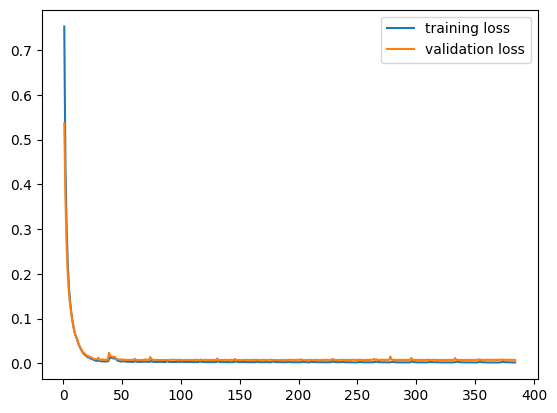

In [119]:
# @title

train_loss_plot = []
val_loss_plot = []
epochs_plot = []

best_val_loss = float('inf')
epochs_without_improvement = 0

for e in range(epochs):
    if e % 10 == 0:
      print(f"Epoch {e}\n-------------------------------")
    size = len(train_dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    train_loss_sum = 0
    num_train_batches = 0
    for batch, (X, y) in enumerate(train_dataloader):
        # Compute prediction and loss
        # X = torch.swapaxes(X, 0, 2)
        pred = model(X)
        y = torch.unsqueeze(y, dim=1)
        loss = loss_fn(pred, y)
        train_loss_sum += loss.item()
        num_train_batches += 1
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if e % 10 == 0:
          if batch % 100 == 0:
              loss, current = loss.item(), (batch + 1) * len(X)
              print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss_plot.append(train_loss_sum/num_train_batches)

    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(val_dataloader.dataset)
    num_val_batches = len(val_dataloader)
    val_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during val mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in val_dataloader:
            pred = model(X)
            y = torch.unsqueeze(y, dim=1)
            val_loss += loss_fn(pred, y).item()
            # correct += (pred == y).type(torch.float).sum().item()

    val_loss /= num_val_batches
    val_loss_plot.append(val_loss)
    epochs_plot.append(e+1)

    if e % 10 == 0:
      print(f"val loss: {val_loss:>8f} \n")

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      epochs_without_improvement = 0
      best_model_state = model.state_dict()
    else:
      epochs_without_improvement += 1
      if epochs_without_improvement >= patience:
        break

plt.plot(epochs_plot, train_loss_plot, label = "training loss")
plt.plot(epochs_plot, val_loss_plot, label = "validation loss")
plt.legend()
print('best val loss', best_val_loss)

file_name = f"{datetime.now().strftime('%Y_%m_%d_%H_%M')}_{batch_size}_{e}_{str(f'{best_val_loss:.2g}').split('.')[-1]}"


In [120]:
out_path = os.path.join(r"C:\Users\alexa\Documents\Google Drive\Colab Notebooks\HKJC-ML\model_configs\hkjc5", file_name)
torch.save(best_model_state, out_path)

print(file_name, 'saved')


2023_11_10_18_51_64_383_007 saved
